# Kr NEW Fits

J. A Hernando, C. Herves

April 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May  4 12:07:24 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [6]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEW/Kr/'
runs = 8182, 8183, 8184, 8851

In [7]:
from os import listdir

run = 8851
filenames = listdir(path+str(run))
filenames.sort()
print(len(filenames), filenames[0], filenames[-1])
filenames = [path + str(run) + '/' + ifile for ifile in filenames]

2515 kdst_0000_8551_trigger1_v1.2.0_20191122_krbg.h5 kdst_2514_8551_trigger1_v1.2.0_20191122_krbg.h5


In [8]:
kdst = load_dsts(filenames, "DST", "Events")

In [9]:
kdst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [10]:
names = ['event', 'time', 'S2e', 'X', 'Y', 'Z', 'DT']
sel   = (kdst.nS1 == 1) & (kdst.nS2 == 1)
mkdst = kdst[sel][names]
mkdst['R'] = np.sqrt(mkdst.X**2 + mkdst.Y**2)
mkdst.replace(np.nan, 0.)
mkdst = mkdst.rename(columns = {'S2e' : 'energy', 'X' : 'x', 'Y' : 'y', 'Z' : 'z', 'DT' : 'dtime', 'R' : 'r'})

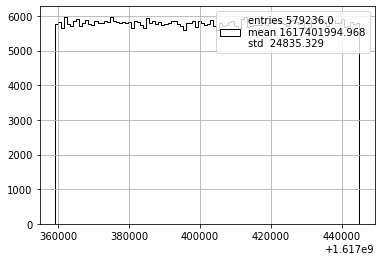

In [11]:
pltext.hist(mkdst.time, 100);

In [12]:
sels = {}
sels['r']        = ut.in_range(mkdst.r  , (0., 180))
sels['dtime']    = ut.in_range(mkdst.dtime , (20, 550.))
sels['energy']   = ut.in_range(mkdst.energy, (6e3, 15e3))
sels['fidutial'] = (sels['r']) & (sels['dtime']) & (sels['energy'])

In [13]:
mkdst.columns

Index(['event', 'time', 'energy', 'x', 'y', 'z', 'dtime', 'r'], dtype='object')

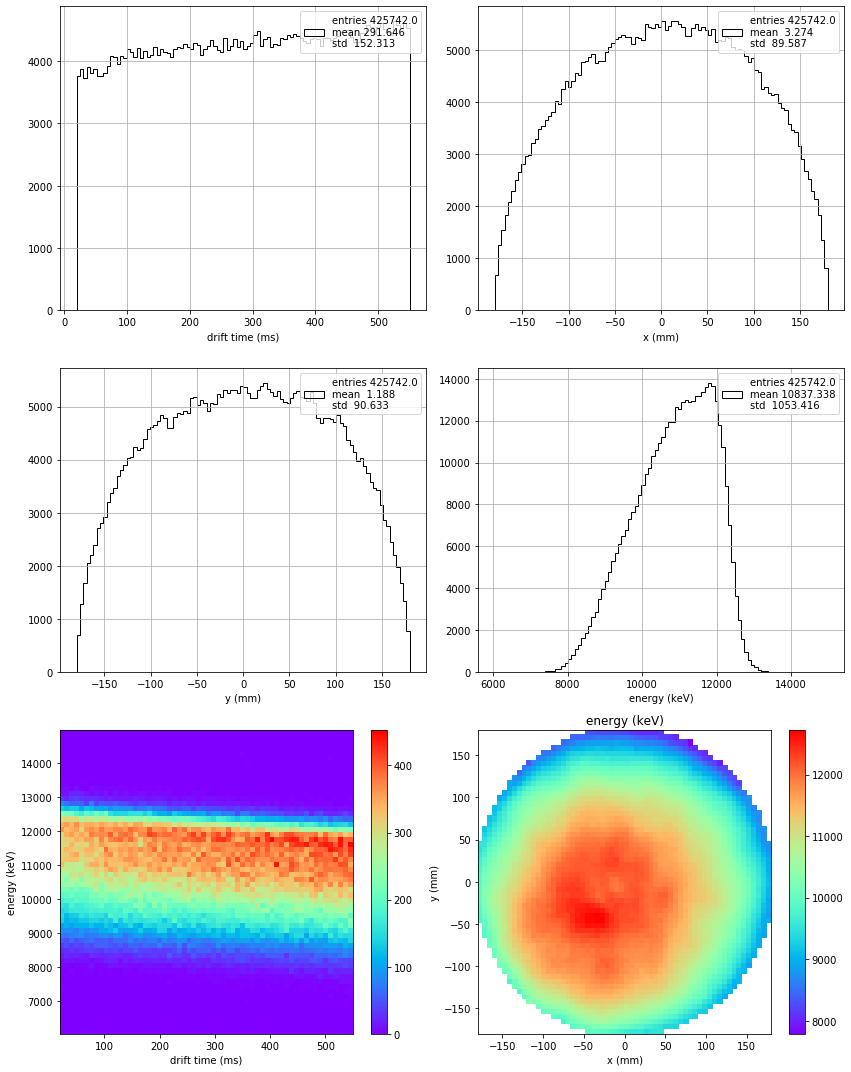

In [14]:
sel = sels['fidutial']
krana.plot_data(mkdst[sel], 60)

## Kr Map

In [15]:
coors  = mkdst[sel].x, mkdst[sel].y
energy = mkdst[sel].energy
dtime  = mkdst[sel].dtime
counts_min = 40
grain  = 2
krmap  = krana.krmap(coors, dtime, energy, bins = (18 * grain, 18 * grain), counts_min = counts_min, dt0 = None)

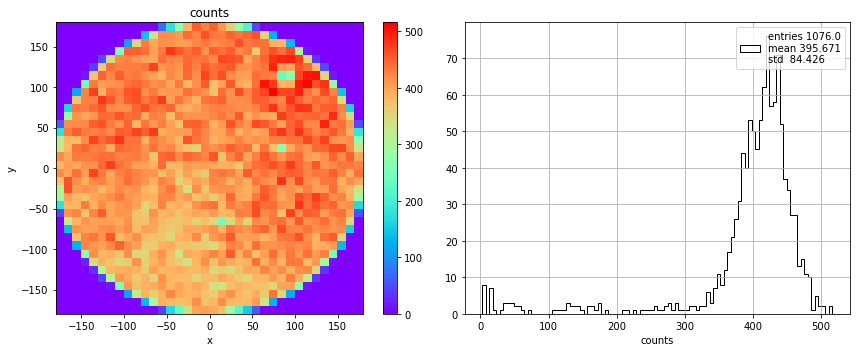

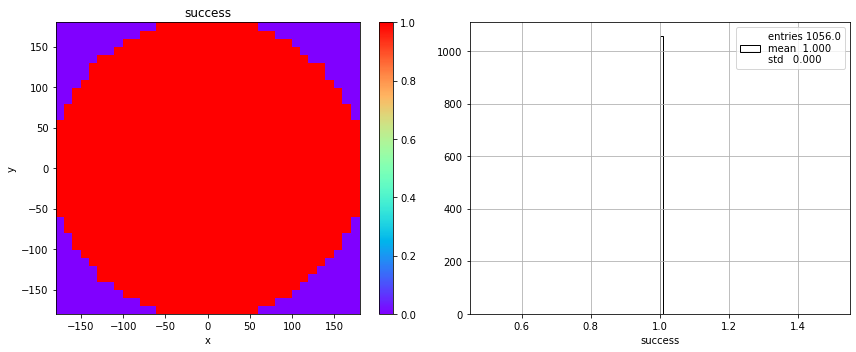

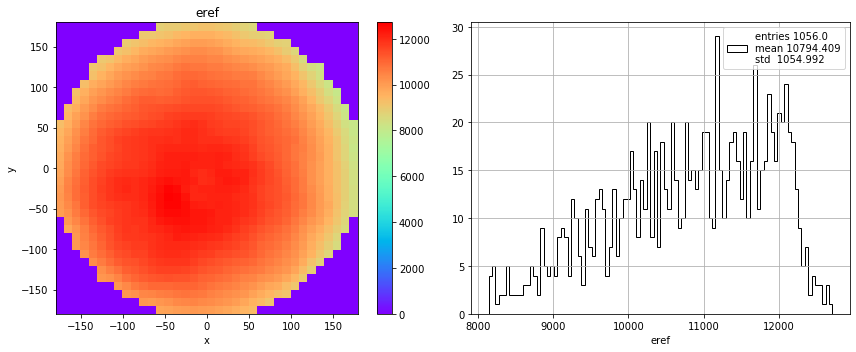

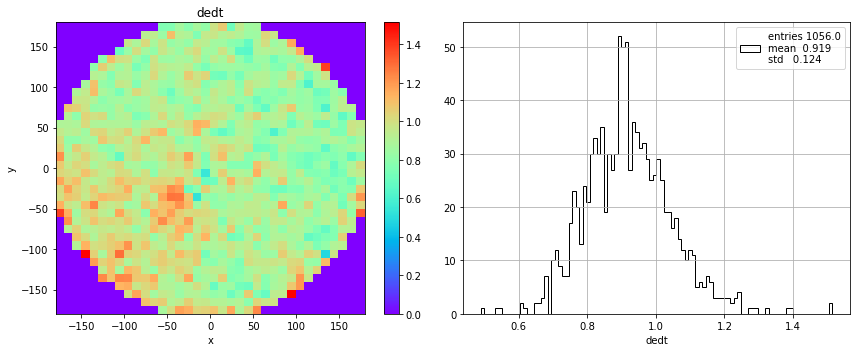

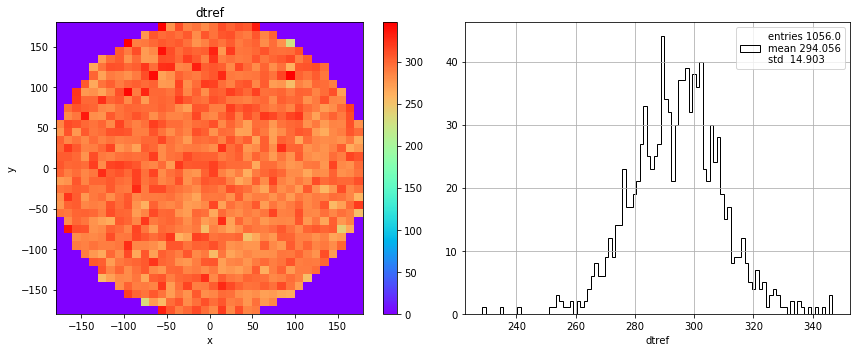

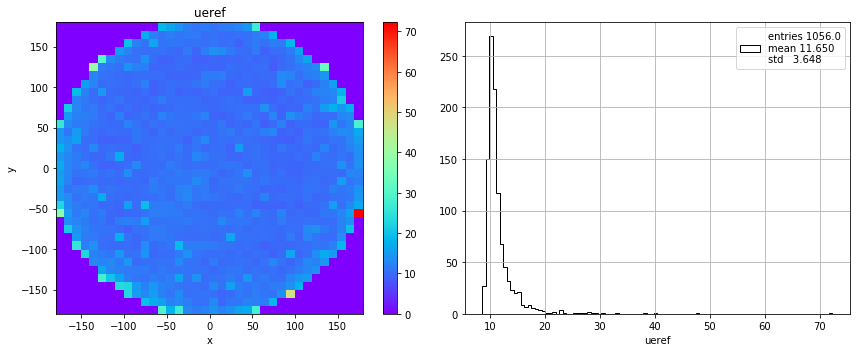

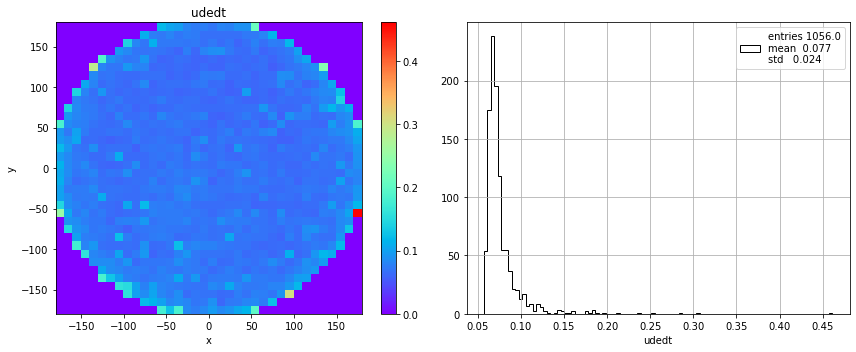

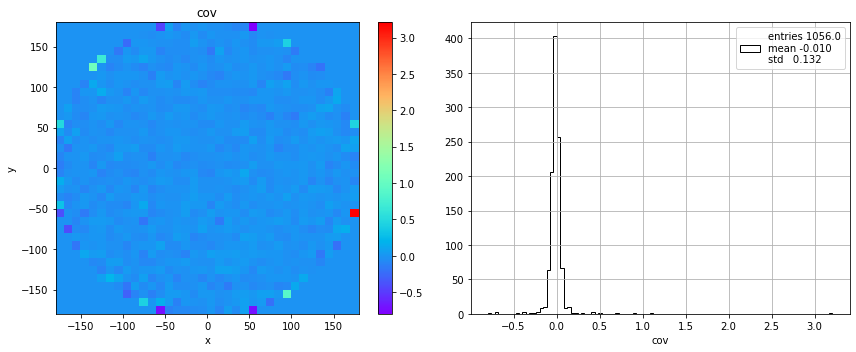

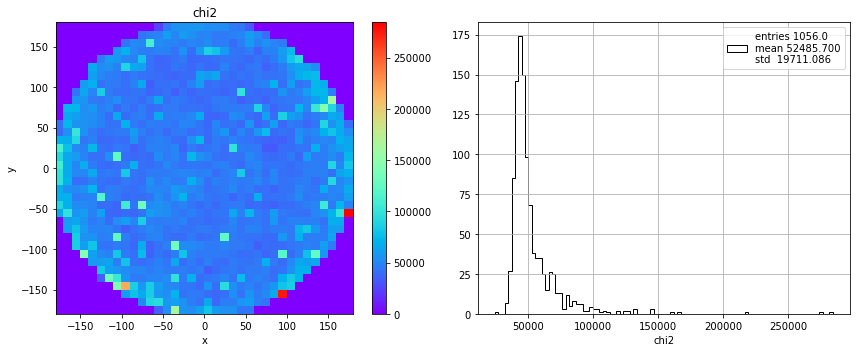

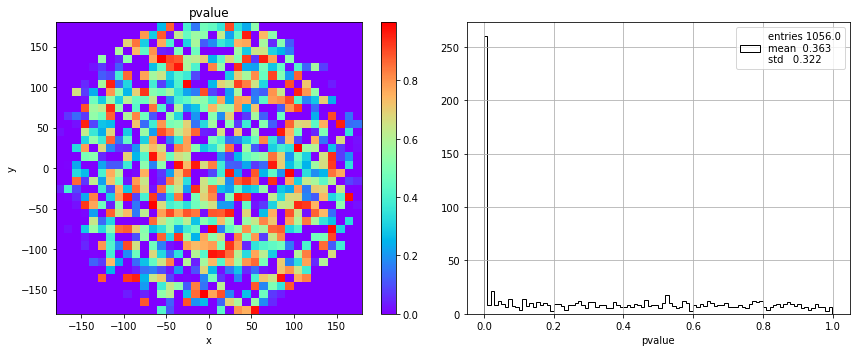

In [16]:
krana.plot_xyvar(krmap.counts , krmap.bin_edges, 'counts' , mask = krmap.counts > 0)
krana.plot_xyvar(krmap.success, krmap.bin_edges, 'success', mask = krmap.success)
krana.plot_xyvar(krmap.eref   , krmap.bin_edges, 'eref'   , mask = krmap.success)
krana.plot_xyvar(krmap.dedt   , krmap.bin_edges, 'dedt'   , mask = krmap.success)
krana.plot_xyvar(krmap.dtref  , krmap.bin_edges, 'dtref'  , mask = krmap.success)
krana.plot_xyvar(krmap.ueref  , krmap.bin_edges, 'ueref'  , mask = krmap.success)
krana.plot_xyvar(krmap.udedt  , krmap.bin_edges, 'udedt'  , mask = krmap.success)
krana.plot_xyvar(krmap.cov    , krmap.bin_edges, 'cov'    , mask = krmap.success)
krana.plot_xyvar(krmap.chi2   , krmap.bin_edges, 'chi2'   , mask = krmap.success)
krana.plot_xyvar(krmap.pvalue , krmap.bin_edges, 'pvalue' , mask = krmap.success)

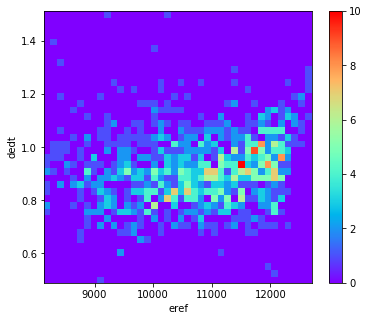

In [22]:
xsel = krmap.success
pltext.canvas(1, 1)
plt.hist2d(krmap.eref[xsel].ravel(), krmap.dedt[xsel].ravel(), (40, 40));
plt.colorbar(); plt.xlabel('eref'); plt.ylabel('dedt');

In [29]:
np.sum(~np.isnan(krmap.residuals))

425422

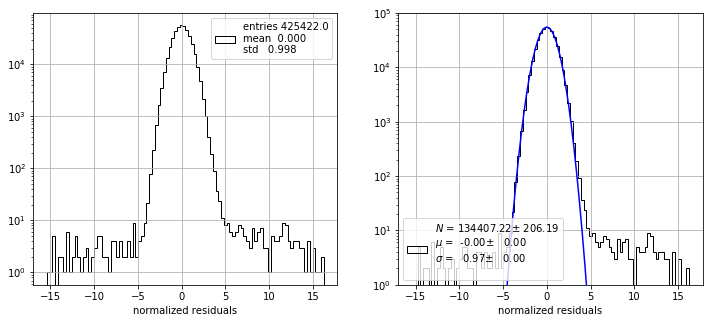

In [31]:
xsel = ~np.isnan(krmap.residuals)
canvas = pltext.canvas(2, 2)
canvas(1)
pltext.hist(krmap.residuals[xsel], 100);
plt.yscale('log');
plt.xlabel('normalized residuals');
canvas(2)
pltext.hfit(krmap.residuals[xsel], 100, 'gaus');
plt.yscale('log'); plt.ylim((1, 1e5));
plt.xlabel('normalized residuals');

## Correction

In [32]:
corr_energy, _ = krana.krmap_scale(coors, dtime, energy, krmap, scale = 41.5)

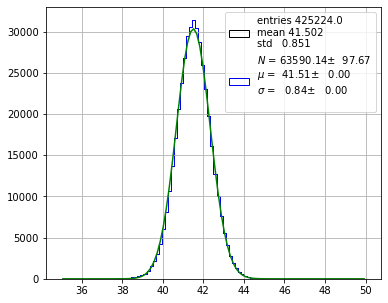

In [38]:
xsel = ~np.isnan(corr_energy)
pltext.canvas(1, 1);
pltext.hist(corr_energy[xsel], 100, (35., 50.));
pltext.hfit(corr_energy[xsel], 100, range = (35., 50.), fun = 'gaus');

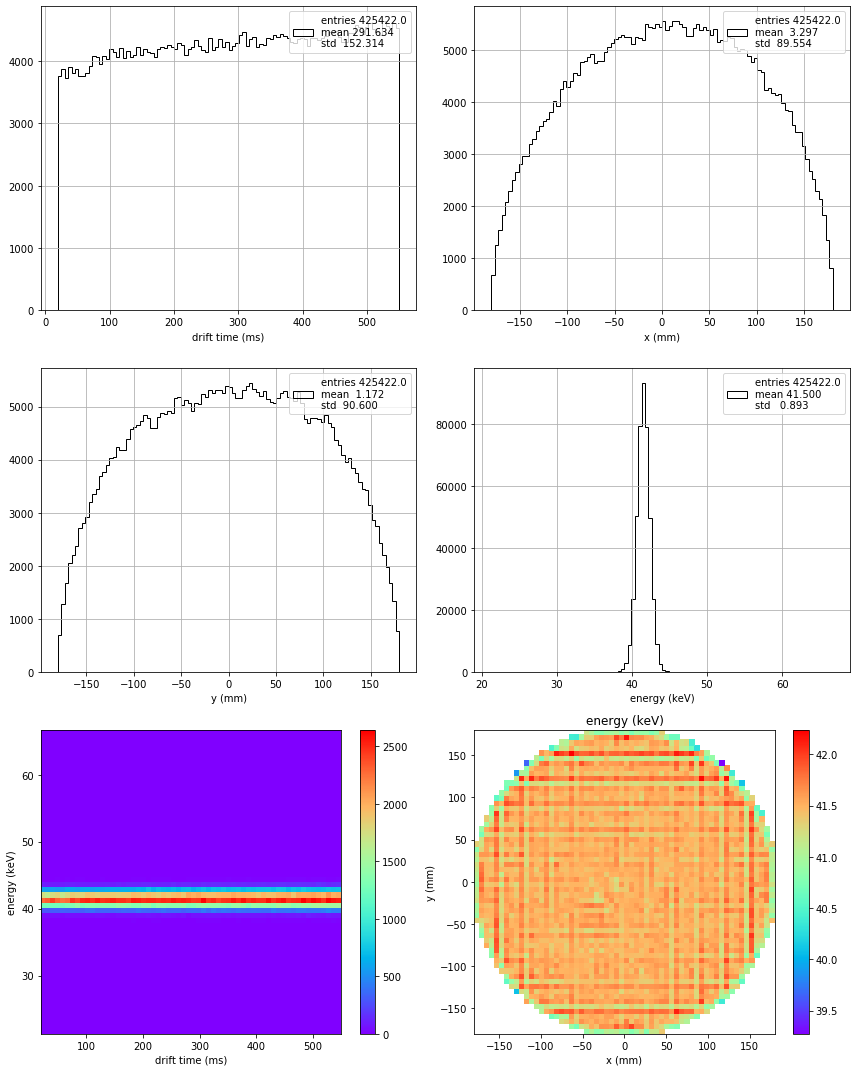

In [39]:
xsel = ~np.isnan(corr_energy)
df = {'x': coors[0][xsel], 'y' : coors[1][xsel], 'dtime': dtime[xsel], 'energy' : corr_energy[xsel]}
df = pd.DataFrame(df)
krana.plot_data(df, bins = 60)

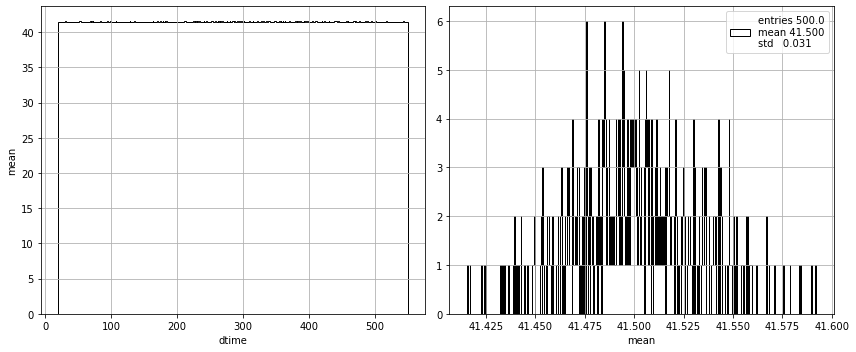

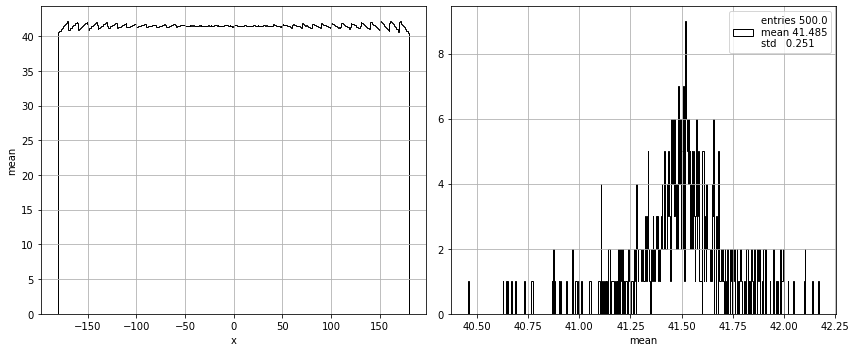

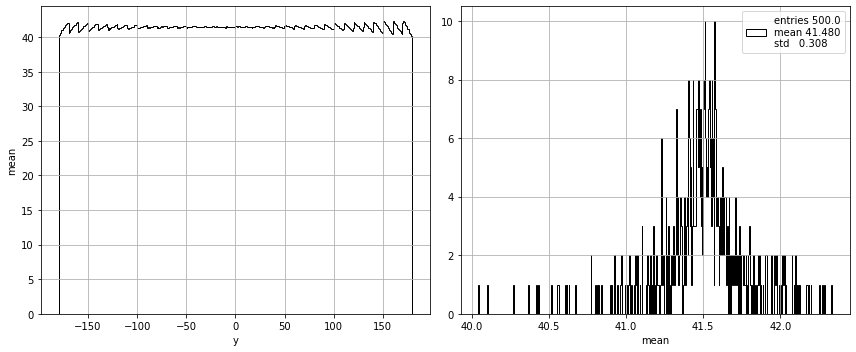

In [41]:
krana.plot_xydt_energy_profiles(df, nbins = 500)

## Refine the correction

In [42]:
xsel   = df.energy > 0.
coors  = df.x[xsel], df.y[xsel]
enes   = df.energy[xsel]
xyprof = prof.profile(coors, enes, 180)

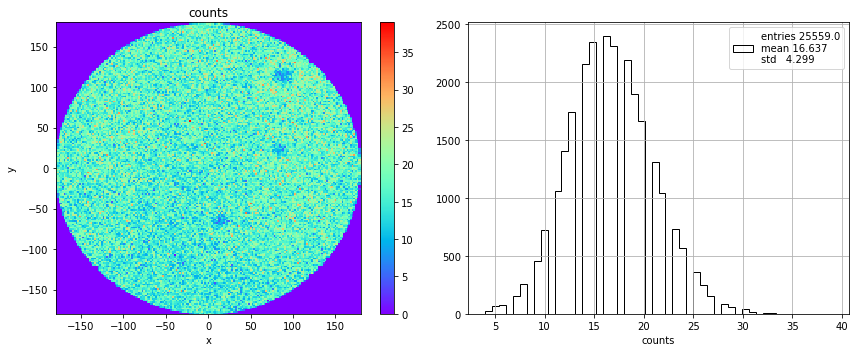

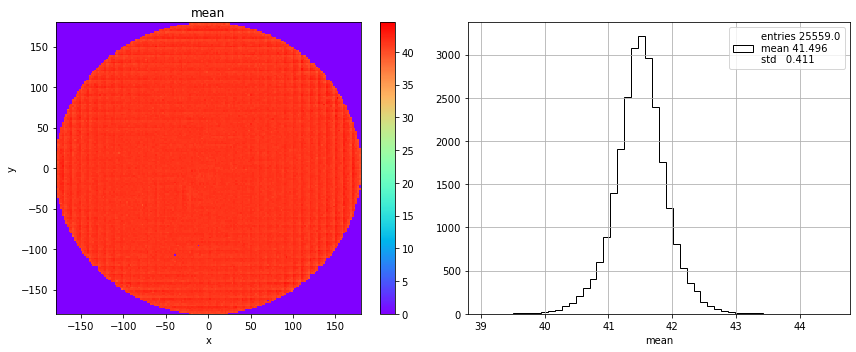

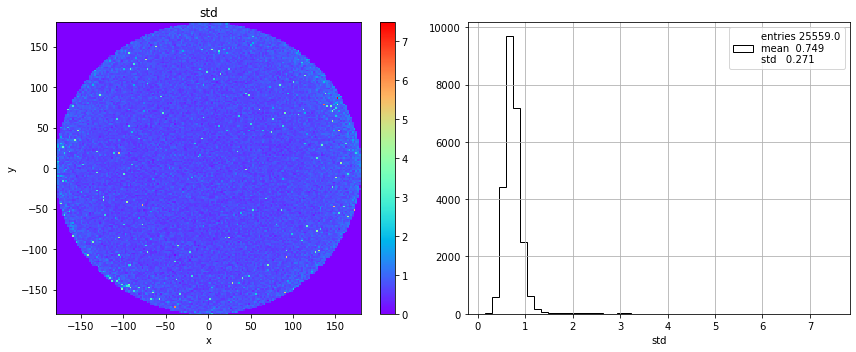

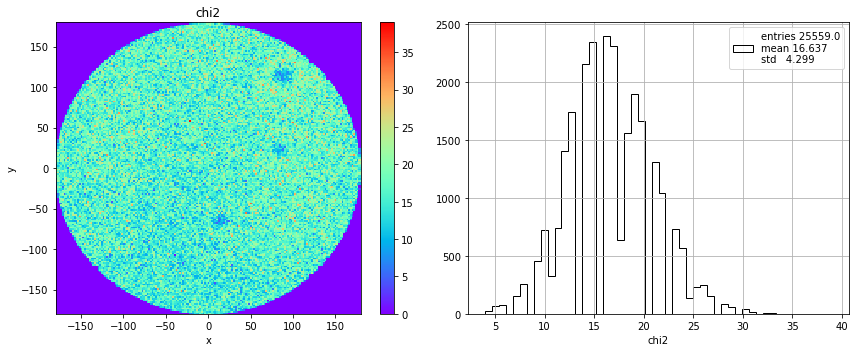

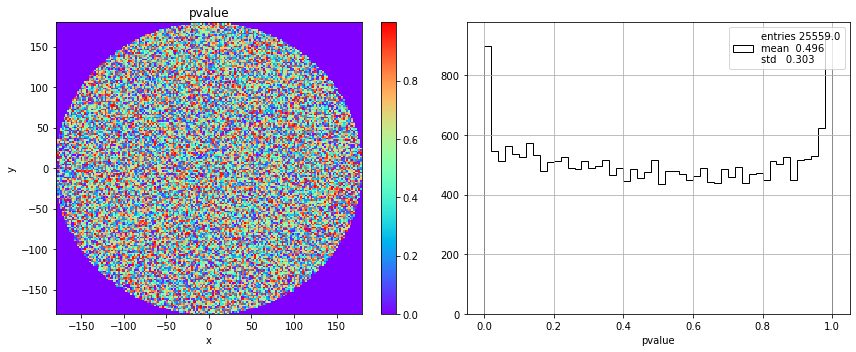

In [43]:
prof.plot_profile(xyprof);

In [44]:
correne = prof.profile_scale(coors, enes, xyprof, 41.5)

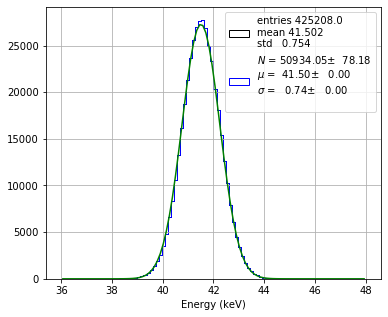

In [45]:
pltext.canvas(1, 1);
pltext.hist(correne, 100, (36, 48));
pltext.hfit(correne, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)');

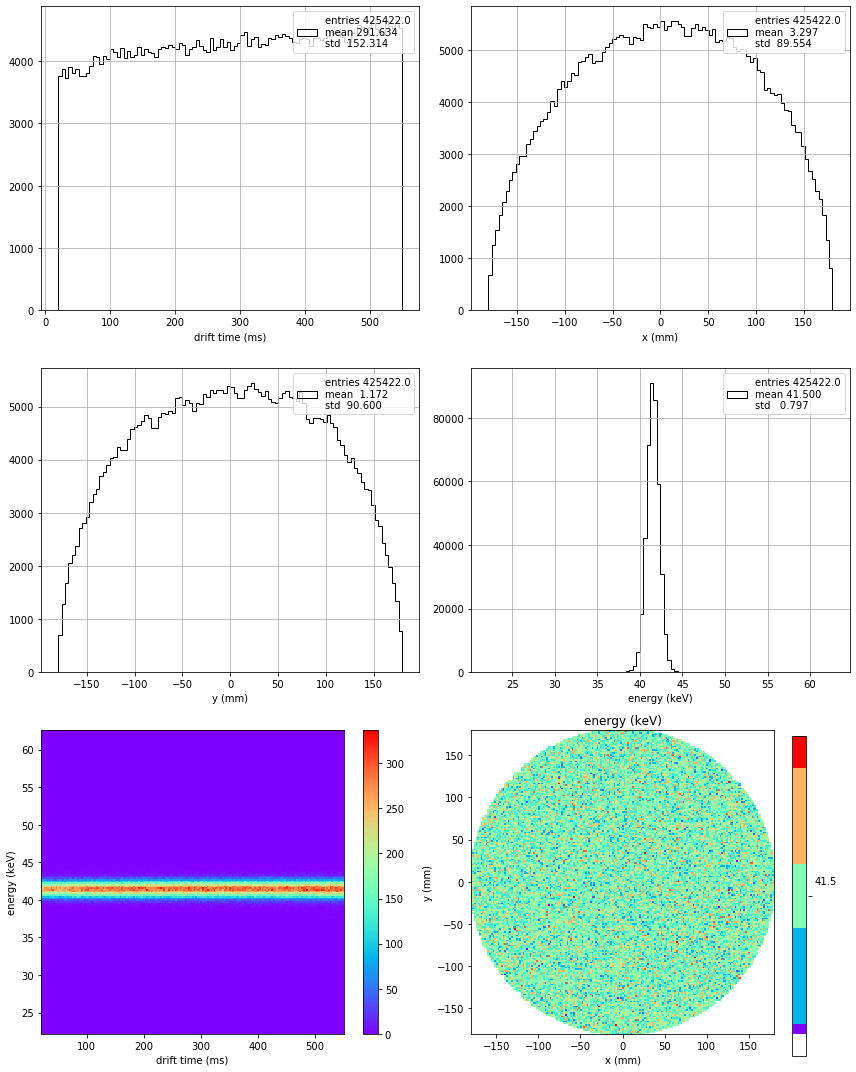

In [46]:
xdf = {'x': df.x[xsel], 'y': df.y[xsel], 'dtime': df.dtime[xsel], 'energy': correne}
xdf = pd.DataFrame(xdf)
krana.plot_data(xdf, bins = 180)

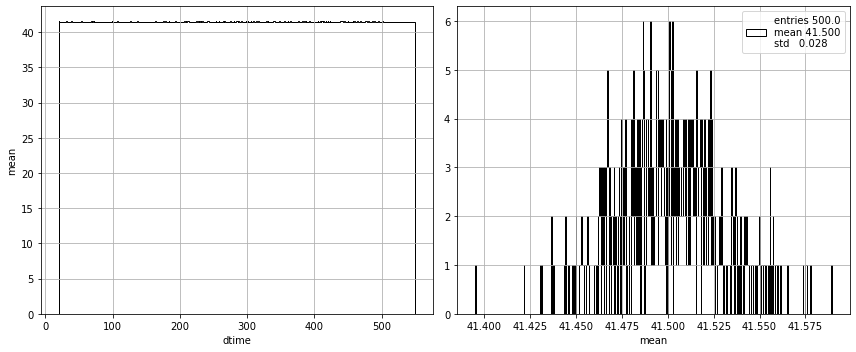

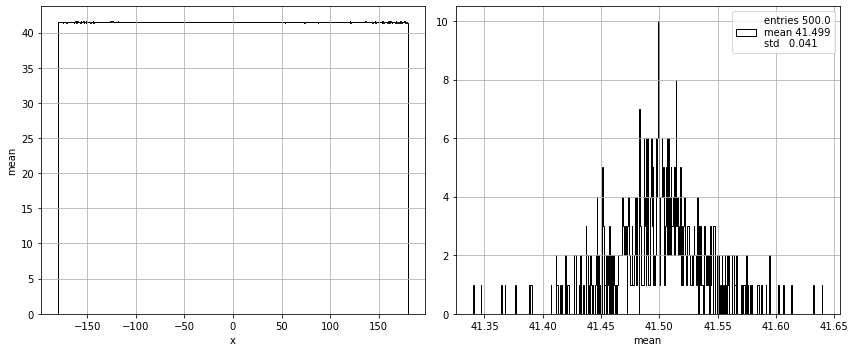

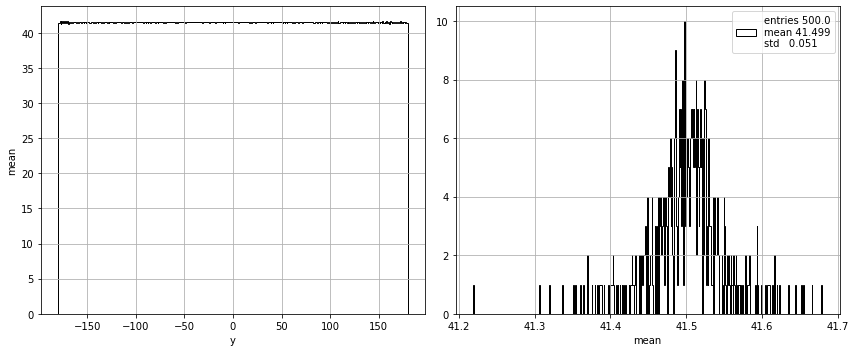

In [47]:
krana.plot_xydt_energy_profiles(xdf[xdf.energy > 0.], nbins = 500)